In [ ]:
#install packages not native to Colabs
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.3 MB/s 
     |████████████████████████████████| 101 kB 14.7 MB/s 
     |████████████████████████████████| 596 kB 71.3 MB/s 
     |████████████████████████████████| 6.6 MB 51.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 17.3 MB/s 


In [ ]:
#%tensorflow_version 2.x
import tensorflow as tf
import transformers
import numpy as np
import pandas as pd
import sklearn
import csv
import nltk
import random
import torch
import re
random.seed(1234) 
np.random.seed(1234)
torch.manual_seed(1234) 
tf.random.set_seed(1234)
from transformers import InputExample, InputFeatures
from transformers import AdamW, get_linear_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

totaldf=pd.read_csv('/content/drive/MyDrive/All Item Classification/Training Dataset_Mostly Agri And Tech.csv', header=0, encoding='latin-1')
totaldf = totaldf[['Item','Exiobase Spend Category']]
totaldf['Exiobase Spend Category'].value_counts()
totaldf

Item  Exiobase Spend Category
0                                             Beef  Products of meat cattle
1                Abondance cheese, from cow's milk           Dairy products
2          Apricot, canned in light syrup, drained        Food products nec
3      Apricot, canned in light syrup, not drained        Food products nec
4               Apricot, in syrup, canned, drained        Food products nec
...                                            ...                      ...
20763                                Other service           Other services
20764                                      T Shirt                 Textiles
20765                                        Pants                 Textiles
20766                                        Dress                 Textiles
20767                                       Shorts                 Textiles

[20768 rows x 2 columns]

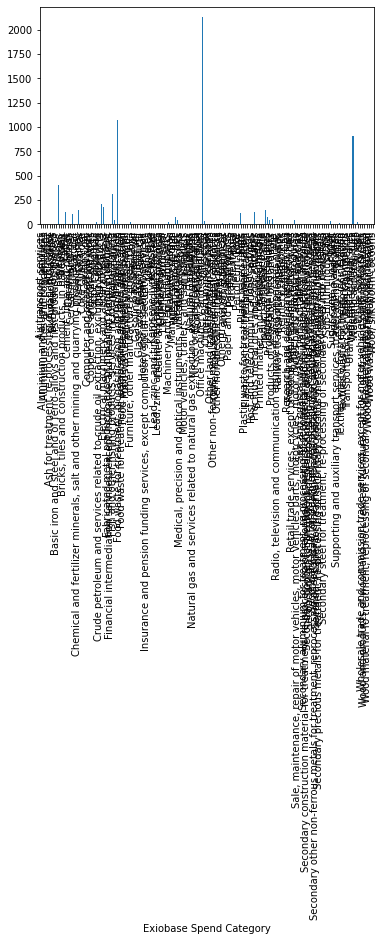

In [ ]:
# Drop all rows with NaN values
totaldf = totaldf.dropna().reset_index(drop=True)

# Drop duplicates
totaldf.drop_duplicates(inplace=True)
totaldf.groupby(['Exiobase Spend Category']).size().plot.bar() #Still highly Unbalanced after dropping duplicate rows

In [ ]:
totaldf['Exiobase Spend Category'].value_counts()

Office machinery and computers                                     2128
Food products nec                                                  1070
Vegetables, fruit, nuts                                             910
Beverages                                                           400
Fish and other fishing products; services incidental of fishing     311
                                                                   ... 
Food waste for treatment: landfill                                    2
Food waste for treatment: incineration                                2
Food waste for treatment: composting and land application             2
Food waste for treatment: biogasification and land application        2
Other services                                                        2
Name: Exiobase Spend Category, Length: 149, dtype: int64

In [ ]:
#Remove classes with only 1 sample
label_lst = totaldf['Exiobase Spend Category'].value_counts().index.tolist()

for label in label_lst:
  if len(totaldf[totaldf['Exiobase Spend Category'] == label]) <=1:
    totaldf = totaldf[totaldf['Exiobase Spend Category'] != label]


totaldf['Exiobase Spend Category'].value_counts()

Office machinery and computers                                     2128
Food products nec                                                  1070
Vegetables, fruit, nuts                                             910
Beverages                                                           400
Fish and other fishing products; services incidental of fishing     311
                                                                   ... 
Food waste for treatment: landfill                                    2
Food waste for treatment: incineration                                2
Food waste for treatment: composting and land application             2
Food waste for treatment: biogasification and land application        2
Other services                                                        2
Name: Exiobase Spend Category, Length: 149, dtype: int64

In [ ]:
totaldf['Exiobase Spend Category'].value_counts()

labels = {}
i = 0
for catName in set(totaldf['Exiobase Spend Category']):
  labels[catName] = i
  i+=1

labels

{'Air transport services': 95,
 'Aluminium and aluminium products': 57,
 'Aluminium ores and concentrates': 23,
 'Anthracite': 130,
 'Ash for treatment, re-processing of ash into clinker': 44,
 'Aviation Gasoline': 131,
 'BKB/Peat Briquettes': 72,
 'Basic iron and steel and of ferro-alloys and first products thereof': 116,
 'Beverages': 124,
 'Bitumen': 141,
 'Bricks, tiles and construction products, in baked clay': 92,
 'Cattle': 16,
 'Cement, lime and plaster': 47,
 'Ceramic goods': 12,
 'Cereals grains nec': 143,
 'Charcoal': 112,
 'Chemical and fertilizer minerals, salt and other mining and quarrying products n.e.c.': 74,
 'Chemicals nec': 54,
 'Coal Tar': 128,
 'Coke Oven Coke': 118,
 'Coking Coal': 64,
 'Computer and related services': 6,
 'Construction work': 40,
 'Copper ores and concentrates': 28,
 'Copper products': 114,
 'Crops nec': 7,
 'Crude petroleum and services related to crude oil extraction, excluding surveying': 35,
 'Dairy products': 126,
 'Electrical machinery and

In [ ]:
list(set(totaldf['Exiobase Spend Category']))

['Secondary steel for treatment, re-processing of secondary steel into new steel',
 'Printed matter and recorded media',
 'Motor Gasoline',
 'Stone',
 'Sugar',
 'Food waste for treatment: biogasification and land application',
 'Computer and related services',
 'Crops nec',
 'Ethane',
 'Precious metal ores and concentrates',
 'Naphtha',
 'Leather and leather products',
 'Ceramic goods',
 'Lubricants',
 'Fish products',
 'Textiles waste for treatment: landfill',
 'Cattle',
 'Wool, silk-worm cocoons',
 'Fabricated metal products, except machinery and equipment',
 'Products of meat poultry',
 'Sub-Bituminous Coal',
 'Manure - conventional',
 'Liquefied Petroleum',
 'Aluminium ores and concentrates',
 'Paraffin Waxes',
 'Other land transportation services',
 'Wearing apparel; furs',
 'Motor vehicles, trailers and semi-trailers',
 'Copper ores and concentrates',
 'Natural gas and services related to natural gas extraction, excluding surveying',
 'Supporting and auxil',
 'Raw milk',
 'Wood m

In [ ]:
#change exiobase spend category label from text to numbers for bert to read
totaldf['Exiobase Spend Category'] = totaldf['Exiobase Spend Category'].apply(lambda x: labels[x])

### **Cleaning Dataset Items column and splitting to train validate**

In [ ]:
#Clean items column in dataset first
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text
    
totaldf['Item'] = totaldf['Item'].apply(clean_text)
totaldf.iloc[621] #previously is 'Pumpkin (cucurbita moschata), pulp, raw'

traindf, validdf = train_test_split(totaldf, test_size=0.2, shuffle=True, stratify=totaldf["Exiobase Spend Category"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **BERT**

In [ ]:
#Function for encoding data
class TrainDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding=True,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids)
        print("1:",input_ids)

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
#Function for DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TrainDataset(
    reviews=df['Item'].to_numpy(),
    targets=df['Exiobase Spend Category'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
#Import tokenizer and set the Max Length after tokenization
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 0


# For every sentence...
for sent in pd.concat([traindf['Item'],validdf['Item']],ignore_index=True):
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    MAX_LEN = max(MAX_LEN, len(input_ids))
    if len(input_ids) == MAX_LEN:
      print(sent,MAX_LEN)

# # #Make sure MAX_LEN is even number cause i will be reshaping val_data_loader inside eval_model() to 2 arrays in 2D
# # if MAX_LEN % 2 == 1:
# #   MAX_LEN += 1

print('Max sentence length: ', MAX_LEN)

mackerel canned brine drained 9
biscuit small tart chocolate prepacked 11
biscuit extruded grilled chocolate filling 11
dark chocolate bar fruits orange raspberries pear 11
mineral water san benedetto bottled lightly mineralized 12
mineral still water clos de labbaye bottled averagely mineralized 16
apc smartups online 2200va lithiumion rackmount 3u 230v 6x c13+2x c19 iec outlets smartslot extended runtime w rail kit 38
apple 12inch macbook models mnyf2 mnyg2 mnyh2 mnyj2 mnyk2 mnyl2 mnym2 mnkn2 38
Max sentence length:  38


In [ ]:
#Process the data from train, validation, test
BATCH_SIZE = 2
train_data_loader = create_data_loader(traindf, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(validdf, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
#import the model and save to GPU/CPU
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(labels)) #change number of labels to number of classes
model = model.to(device)

#Can reduce Epochs if insufficient memory
EPOCHS = 5
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from sklearn import metrics

#Create the training function and display the results
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(2,MAX_LEN).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader: #referring to validation data loader (val_dat_loader)
            print('Max_Len:',MAX_LEN)
            print('D:',d)
            input_ids = d["input_ids"].reshape(2,MAX_LEN).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(traindf)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(validdf)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        #torch.save(model.state_dict(), '/content/drive/MyDrive/Assignment 2/Models.py')
        best_accuracy = val_acc

# Val loss 0.7041286662953292 Val accuracy 0.8801213960546282
# CPU times: user 19min 5s, sys: 2min 21s, total: 21min 26s
# Wall time: 26min 3s

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3016, 18256, 21391, 10654,  6315, 20482,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  6207,  6207,  2694,  4275,  9108, 16147,  2683,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3816, 10962, 24816,  4800, 28403, 10020,   102,     0,     0,
             0,     0,     0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
1: tensor([[  101, 18798, 16059,  2228, 15455,  1060,  2487, 13272,  3416,  8991,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101, 10733,  3142,  2050,  7708,  3201, 12278,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  8808,  2524, 11968,  7834,  2319,  3590, 10882, 22117,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101, 12418, 15

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


1: tensor([[  101, 11349,  7869,  2140, 27141,  7987,  3170, 11055,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3016, 18256, 21391, 10654,  6315, 20482,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  6207,  6207,  2694,  4275,  9108, 16147,  2683,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3816, 10962, 24816,  4800, 28403, 10020,   102,     0,     0,
             0,     0,     0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
           7396,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0]],

        [[  101, 21569, 24665, 16503,  2015,  6315,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0]]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'targets': tensor([ 79, 143])}
Max_Len: 38
D: {'review_text': ['lentil blond cooked', 'peanut butter glass jar'], 'input_ids

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3016, 18256, 21391, 10654,  6315, 20482,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  6207,  6207,  2694,  4275,  9108, 16147,  2683,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3816, 10962, 24816,  4800, 28403, 10020,   102,     0,     0,
             0,     0,     0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


1: tensor([[  101,  7043,  2232,  6131,  1039, 19481,  2692,  2549, 10288, 13102,
          2290,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
              0,     0,     0,     0,     0,     0,     0,     0]]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'targets': tensor([ 79, 143])}
Max_Len: 38
D: {'review_text': ['lentil blond cooked', 'peanut butter glass jar'], 'input_ids': tensor([[[  101, 15307,  4014,  8855, 12984,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0]],

        [[  101, 21443, 12136,  3221, 15723,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


1: tensor([[  101, 11349,  7869,  2140, 27141,  7987,  3170, 11055,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  7273,  7954,  6090,  5654, 15478,  7975,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3016, 18256, 21391, 10654,  6315, 20482,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  6207,  6207,  2694,  4275,  9108, 16147,  2683,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3816, 10962, 24816,  4800, 28403, 10020,   102,     0,     0,
             0,     0,     0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
              0,     0,     0,     0,     0,     0,     0,     0]],

        [[  101, 21443, 12136,  3221, 15723,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0]]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'targets': tensor([81, 45])}
1: tensor([[  101,  7842,  6371,  4013,  6282, 11387,  2015,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


1: tensor([[  101, 11349,  7869,  2140, 27141,  7987,  3170, 11055,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3016, 18256, 21391, 10654,  6315, 20482,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  6207,  6207,  2694,  4275,  9108, 16147,  2683,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1: tensor([[  101,  3816, 10962, 24816,  4800, 28403, 10020,   102,     0,     0,
             0,     0,     0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


1: tensor([[  101,  7043,  2232,  6131,  1039, 19481,  2692,  2549, 10288, 13102,
          2290,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Streaming output truncated to the last 5000 lines.
              0,     0,     0,     0,     0,     0,     0,     0]]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'targets': tensor([ 79, 143])}
Max_Len: 38
D: {'review_text': ['lentil blond cooked', 'peanut butter glass jar'], 'input_ids': tensor([[[  101, 15307,  4014,  8855, 12984,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0]],

        [[  101, 21443, 12136,  3221, 15723,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     

In [ ]:
# https://www.baeldung.com/cs/training-validation-loss-deep-learning
history

defaultdict(list,
            {'train_acc': [0.6782576866764275,
              0.8138726207906296,
              0.8658491947291361,
              0.9068448023426061,
              0.9317349926793558],
             'train_loss': [1.4785529659173782,
              0.8538717599651194,
              0.6274542369328415,
              0.45878772682769453,
              0.3404828087704122],
             'val_acc': [0.7635431918008785,
              0.7964860907759883,
              0.8228404099560761,
              0.8294289897510981,
              0.8338213762811127],
             'val_loss': [1.15464608178691,
              1.102726105838465,
              1.0149586515943163,
              0.9502347247563748,
              0.9483534337795954]})

In [ ]:
#Save parameters for future retrieval
torch.save(model.state_dict(), '/content/drive/MyDrive/All Item Classification/bertModelparams_all_labels_v2.pt')

In [ ]:
#Create function to formulate prediction on test set
def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,MAX_LEN).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)
    print('p: ',prediction)
    print(f'Review text: {review_text}')
    print("Array scores:",probs)
    print("Array scores:",probs[class_names[prediction]])
    return class_names[prediction]

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(labels))
model.load_state_dict(torch.load('/content/drive/MyDrive/Unravel Carbon/bertModelparamsAgriTech.pt'))
model = model.to(device)
class_names=list(set(totaldf['Exiobase Spend Category'])) #check if the sequence is correct

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
reverse_labels = {}
for key,value in labels.items():
  reverse_labels[value] = key


In [ ]:
test="samsung galaxy s10"
print(predict_sentiment(test))
print(reverse_labels[predict_sentiment(test)])

p:  tensor(8)
Review text: samsung galaxy s10
Array scores: [0.00012304999108891934, 0.00013226477312855422, 0.0002526416501495987, 8.276286826003343e-05, 1.5398985851788893e-05, 0.00017792756261769682, 0.0002524360897950828, 2.2449195967055857e-05, 0.6227419972419739, 5.723633512388915e-05, 1.8726763300946914e-05, 7.265733438543975e-05, 0.00010252611536998302, 7.475882739527151e-05, 9.114123531617224e-05, 3.173536970280111e-05, 2.098354343615938e-05, 0.0001473811425967142, 0.37257540225982666, 2.498625144653488e-05, 0.00019569364667404443, 0.00011517562961671501, 1.007300761557417e-05, 3.886445483658463e-05, 2.4314935217262246e-05, 0.0004831441619899124, 8.280084148282185e-05, 0.0002220087480964139, 6.196081085363403e-05, 2.9493437978089787e-05, 0.0002233761188108474, 0.0010180225363001227, 0.00011971677304245532, 0.00017973706417251378, 0.00017705837672110647]
Array scores: 0.6227419972419739
8
p:  tensor(8)
Review text: samsung galaxy s10
Array scores: [0.00012304999108891934, 0.000